## Overdensity probability distributions

In this notebook we plot the distribution of galaxy overdensities calculated at different redshifts and with differing aperture configurations.

`overdensity_cylinder.py` is the script used for calculating overdensity in a given cylinder configuration for a given galaxy selection, including redshift distortions, and is called as so:

``` 
python overdensity_cylinder.py selection_string redshift_str random_bool R half_deltac
```

- `selection_str` is the selection (`sfr` or `stellarMass`)
- `redshift_str` is the redshift selection (e.g. `2p07`) 
- random_bool is a boolean specifying whether to calculate the overdensity for randomly placed regions (`1`) or for each galaxy (`0`)
- `R` is the cylindircal radius in $h^{-1} \mathrm{cMpc}$
- `half_deltac` is half the depth of the cylinder in $h^{-1} \mathrm{cMpc}$

In [1]:
import pandas as pd
import numpy as np

import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

from methods import bhattacharyya
from methods import plotit

Load previously calculated overdensity data

In [2]:
# directory = 'data/r200/'
# out_directory ='../papers/protoclusters/images/'

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory ='../'

Load each calculated `dgal` individually for each specific plot.

In [11]:
# gals = pd.read_csv('data/r200/henriques2015a_z6p97_stellarMass_r200.csv', skiprows=122, skipfooter=1, engine='python')

In [12]:
dgal_sfr_2p07_r7_random = pcl.load(open(directory+'dgal_sfr_z2p07_r7p0_random.pcl','rb'))
dgal_sfr_3p10_r7_random = pcl.load(open(directory+'dgal_sfr_z3p10_r7p0_random.pcl','rb'))
dgal_sfr_5p92_r7_random = pcl.load(open(directory+'dgal_sfr_z5p92_r7p0_random.pcl','rb'))

In [13]:
dgal_sfr_3p95_r4_random = pcl.load(open(directory+'dgal_sfr_z3p95_r4p0_random.pcl','rb'))
dgal_sfr_3p95_r7_random = pcl.load(open(directory+'dgal_sfr_z3p95_r7p0_random.pcl','rb'))
dgal_sfr_3p95_r10_random = pcl.load(open(directory+'dgal_sfr_z3p95_r10p0_random.pcl','rb'))

In [14]:
dgal_stellarMass_3p95__r7_random = pcl.load(open(directory+'dgal_stellarMass_z3p95_r7p0_random.pcl','rb'))
dgal_stellarMass10_3p95_r7_random = pcl.load(open(directory+'dgal_stellarMass10_z3p95_r7p0_random.pcl','rb'))

In [15]:
print dgal_sfr_2p07_r7_random.shape
print dgal_sfr_3p10_r7_random.shape
print dgal_sfr_5p92_r7_random.shape
print dgal_sfr_3p95_r4_random.shape
print dgal_sfr_3p95_r7_random.shape
print dgal_sfr_3p95_r10_random.shape
print dgal_stellarMass_3p95__r7_random.shape
print dgal_stellarMass10_3p95_r7_random.shape

(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)
(1, 3, 200000, 4)


`plotit` method plots both the fractional overdensity distribution and the pdf. 

In [26]:
# def plotit(ax, selection, rid, zid, axb=None, clim = 0.5, plim = 0.5, N = 12, noplot=False):
#     """
    
#     Args:
#         ax - axis object
#         selection - selection object
#         rid - id of radius selection in selection object
#         zis - if od redshift selection in selection object
#         axb - bottom axis object. If None, only plots 
    
#     """
#     colors = ['dimgrey','lightseagreen','lightcoral', 'y']
    
#     dgal = selection[rid,zid,:,0] + 1
#     completeness = selection[rid,zid,:,1]
#     purity = selection[rid,zid,:,2]
#     mass = selection[rid,zid,:,3]

#     # initialise empty label array
#     label = np.zeros(selection.shape[2])    
    
#     labels = [0,11,12,21,22,31,32]
    
#     mlim = 5e4

#     # assign labels. split by configuration and descendant mass
#     label[(completeness >= clim) & (purity >= plim) & (mass < mlim)] = labels[1]   # protocluster, M < M_lim
#     label[(completeness >= clim) & (purity >= plim) & (mass >= mlim)] = labels[2]  # protocluster, M >= M_lim
#     label[(completeness < clim) & (purity >= plim) & (mass >= mlim)] = labels[3]   # part protocluster, M < M_lim
#     label[(completeness < clim) & (purity >= plim) & (mass >= mlim)] = labels[4]   # part protocluster, M >= M_lim
#     label[(completeness >= clim) & (purity < plim) & (mass < mlim)] = labels[5]    # protocluster+field, M < M_lim
#     label[(completeness >= clim) & (purity < plim) & (mass >= mlim)] = labels[6]   # protocluster+field, M >= M_lim
#     label[(completeness < clim) & (purity < plim)] = labels[0]     # field
    
#     # initialise bins and limits
#     binLimits = np.linspace(0, int(np.max(dgal)+1), N)

#     lower_bin = binLimits[1] + (binLimits[0]-binLimits[1])/2. 
#     upper_bin = binLimits[-1] + (binLimits[0]-binLimits[1])/2.

#     bins = np.linspace(lower_bin, upper_bin, N-1)
    
#     # save counts for each label
#     agg = [[] for x in labels]
    
#     # agg[0] = np.histogram(dgal, binLimits)[0]    # total count
    
#     for i, x in enumerate(labels):
#         agg[i] = np.histogram(dgal[label==x], binLimits)[0]
    
#     agg_total = np.sum(agg,axis=0).astype(float)
    
#     # truncate range to where there are at least a couple of samples
#     n_limit = 1
#     if (np.sum(agg_total < n_limit) > 0):
        
#         mask = range(0,np.min(np.where(np.sum(agg,axis=0) < n_limit)))
        
#         bins = bins[mask]
#         binLimits = binLimits[range(0, np.max(mask)+2)]
#         agg_total = agg_total[mask]
    
#         for i in range(len(labels)):
#             agg[i] = agg[i][mask]
        

    
#     # probability density function
#     if axb != None:
        
#         phiMax = 0.
        
#         mask = (label==11) | (label==12) | (label==21) | (label==22)
#         phiA = np.histogram(dgal[mask], binLimits, normed=True)[0]

#         mask = (label==0)
#         phiB = np.histogram(dgal[mask], binLimits, normed=True)[0]
        
#         phiMax = np.max(phiA)
        
#         DB, BC = bhattacharyya(phiA*np.diff(binLimits), phiB*np.diff(binLimits))
        
        
#         mask = (label==12) | (label==22)
#         phiC = np.histogram(dgal[mask], binLimits, normed=True)[0]
        
#         DB_himass, BC_himass = bhattacharyya(phiC*np.diff(binLimits), phiB*np.diff(binLimits))

#         if noplot:
#             return round(DB, 2), round(DB_himass, 2)
#             exit
        
#         #axb.text(0.6,0.8, '$D_{B} = %s$'%round(DB, 3), transform=axb.transAxes)

#         # axb.step(bins, phiA, color=colors[1], linestyle='dashed')
#         axb.step(bins, phiB, color=colors[0], linestyle='solid', linewidth=3)
        
#         mask = (label==11)
#         if np.sum(mask) > 5:
#             phi = np.histogram(dgal[mask], binLimits, normed=True)[0]
#             axb.step(bins, phi, color=colors[1], linestyle='solid')
#             phiMax = np.max([phiMax, np.max(phi)])
        
#         mask = (label==12)
#         if np.sum(mask) > 5:
#             phi = np.histogram(dgal[mask], binLimits, normed=True)[0]
#             axb.step(bins, phi, color=colors[1], linestyle='dashed')
#             phiMax = np.max([phiMax, np.max(phi)])
        
#         mask = (label==21)
#         if np.sum(mask) > 5:
#             phi = np.histogram(dgal[mask], binLimits, normed=True)[0]
#             axb.step(bins, phi, color=colors[3], linestyle='solid')
#             phiMax = np.max([phiMax, np.max(phi)])
        
#         mask = (label==22)
#         if np.sum(mask) > 5:
#             phi = np.histogram(dgal[mask], binLimits, normed=True)[0]
#             axb.step(bins, phi, color=colors[3], linestyle='dashed')
#             phiMax = np.max([phiMax, np.max(phi)])
            
            
#         axb.step(bins, phiA, color=colors[1], linestyle='solid', linewidth=3)
#         axb.step(bins, phiA, color=colors[3], linestyle='dotted', linewidth=3)
        
#         axb.set_ylim(0, phiMax + 0.1)
    

#     width = binLimits[2] - binLimits[1]
    
#     plt.rcParams['hatch.color'] = 'black'
#     plt.rcParams['hatch.linewidth'] = 0.5
    
#     ax.bar(bins, agg[1] / agg_total, width=width, 
#            label='protocluster ($M<M_{lim}$)', alpha=0.6, color=colors[1])
    
#     bar = ax.bar(bins, agg[2] / agg_total, width=width, bottom=agg[1] / agg_total,  
#            label='protocluster ($M>M_{lim}$)', alpha=0.8, color=colors[1], hatch='///')

#     ax.bar(bins, agg[3] / agg_total, width=width, bottom=np.sum(agg[1:3],axis=0) / agg_total, 
#            label='part of a \n protocluster', alpha=0.6, color=colors[3]) 
    
#     ax.bar(bins, agg[4] / agg_total, width=width, bottom=np.sum(agg[1:4],axis=0) / agg_total,
#            label='part of a \n protocluster', alpha=0.8, color=colors[3], hatch='///') 

#     ax.bar(bins, agg[5] / agg_total, width=width, bottom= np.sum(agg[1:5],axis=0) / agg_total,
#            label='protocluster \n + field', alpha=0.6, color=colors[2])
    
#     ax.bar(bins, agg[6] / agg_total, width=width, bottom= np.sum(agg[1:6],axis=0) / agg_total,
#            label='protocluster \n + field', alpha=0.8, color=colors[2], hatch='///')

#     ax.bar(bins, agg[0] / agg_total, width=width, 
#            bottom= np.sum(agg[1:],axis=0) / agg_total, color=colors[0], 
#            label='field', alpha=0.2)
    
#     ax.set_xlim(binLimits[0], binLimits[-1])
#     if axb:
#         axb.set_xlim(binLimits[0], binLimits[-1])


Print Bhattacharrya distance ($D_{B}$) for different selections

In [38]:
N = 18

print plotit(1, dgal_sfr_3p95_r4_random, 0, 0, axb=1, N=N, clim=0.3, plim=0.7, noplot=True), "\n", \
plotit(1, dgal_sfr_3p95_r7_random, 0, 1, axb=1, N=N, clim=0.6, plim=0.6, noplot=True), "\n", \
plotit(1, dgal_sfr_3p95_r10_random, 0, 2, axb=1, N=N, clim=0.7, plim=0.3, noplot=True), "\n"

print plotit(1, dgal_sfr_3p95_r4_random, 0, 2, axb=1, N=N, clim=0.4, plim=0.7, noplot=True), "\n", \
plotit(1, dgal_sfr_3p95_r7_random, 0, 2, axb=1, N=N, clim=0.7, plim=0.45, noplot=True), "\n"

print plotit(1, dgal_sfr_3p10_r7_random, 0, 1, axb=1, N=N, clim=0.7, plim=0.5, noplot=True), "\n", \
plotit(1, dgal_sfr_5p92_r7_random, 0, 1, axb=1, N=N, clim=0.6, plim=0.6, noplot=True), "\n"

print plotit(1, dgal_stellarMass_3p95__r7_random, 0, 1, axb=1, N=N, clim=0.7, plim=0.6, noplot=True), "\n", \
plotit(1, dgal_stellarMass10_3p95_r7_random, 0, 1, axb=1, N=N, clim=0.7, plim=0.7, noplot=True), "\n"

(0.94, 0.52) 
(0.8, 0.89) 
(0.51, 0.71) 

(0.84, 0.7) 
(0.68, 0.69) 

(0.73, 0.69) 
(0.82, 0.75) 

(0.72, 0.55) 
(0.3, 0.38) 



Example plot showing both axes.

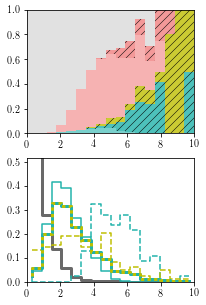

In [28]:
fig, ax = plt.subplots(2,1, figsize=(3,5))

plotit(ax[0], dgal_sfr_2p07_r7_random, 0, 1, axb=ax[1], N=18, clim=0.5, plim=0.5)

Eample without bottom axis

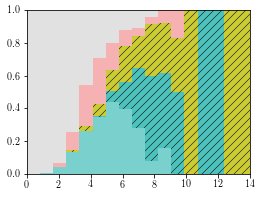

In [34]:
fig, ax = plt.subplots(1,1, figsize=(4,3))

plotit(ax, dgal_sfr_3p95_r7_random, 0, 1, axb=None, N=18, clim=0.5, plim=0.5)

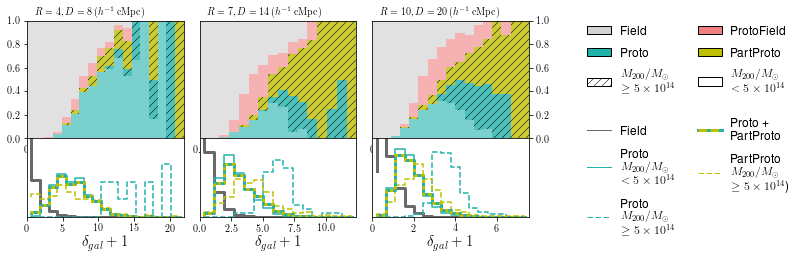

In [24]:
fig = plt.figure(figsize=(9, 13))

gs1 = gridspec.GridSpec(18, 3)
gs1.update(wspace=0.1, hspace=0)

ax1 = fig.add_subplot(gs1[0:3,0])
ax1b = fig.add_subplot(gs1[3:5,0])

ax4 = fig.add_subplot(gs1[0:3,1])
ax4b = fig.add_subplot(gs1[3:5,1])

ax2 = fig.add_subplot(gs1[0:3,2])
ax2b = fig.add_subplot(gs1[3:5,2])

# gs2 = gridspec.GridSpec(18, 2)
# gs2.update(wspace=0.1, hspace=0)

N = 19

Ridx = zidx = 1

plotit(ax4, dgal_sfr_3p95_r7_random, 0, 1, axb=ax4b, N=N, clim=0.6, plim=0.6)
ax4.text(0.05,1.05,'$R = 10, D = 20 \, (h^{-1} \; \mathrm{cMpc})$', transform=ax4.transAxes)

plotit(ax1, dgal_sfr_3p95_r4_random, 0, 0, axb=ax1b, N=N, clim=0.3, plim=0.7)
ax1.text(0.05,1.05,'$R = 6, D = 12 \, (h^{-1} \; \mathrm{cMpc})$', transform=ax1.transAxes)

plotit(ax2, dgal_sfr_3p95_r10_random, 0, 2, axb=ax2b, N=N, clim=0.7, plim=0.3)
ax2.text(0.05,1.05,'$R = 15, D = 30 \, (h^{-1} \; \mathrm{cMpc})$', transform=ax2.transAxes)

ax2.yaxis.tick_right()
ax2b.yaxis.tick_right()


ax4.set_yticks([])
for ax in ([ax1b,ax2b,ax4b]):
    ax.set_yticks([])
    ax.set_xlabel('$\delta_{gal} + 1$', size=15)

# Legend
pat1 = mpatches.Patch(color='lightgrey',label='Field')
pat2 = mpatches.Patch(color='lightseagreen',label='Proto')
pat3 = mpatches.Patch(color='lightcoral',label='ProtoField')
pat4 = mpatches.Patch(color='y',label='PartProto')
patM1 = mpatches.Patch(color='white', hatch='///',label='$M_{200} / M_{\odot}$ \n $\geq 5 \\times 10^{14}$')
patM2 = mpatches.Patch(color='white', hatch='',label='$M_{200} / M_{\odot}$ \n $< 5 \\times 10^{14}$')
colors = ['dimgrey','lightseagreen','lightcoral', 'y']
    
legend = ax2.legend(handles = [pat1,pat2,patM1,pat3,pat4,patM2], bbox_to_anchor=(1.3, 1.05),
                    ncol=2, prop={'size': 12}, labelspacing=0.9)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')

for patch in legend.get_patches():
    patch.set_edgecolor('black')

# Legend

line_field = plt.Line2D((0,1.5),(0,0), color='dimgrey', linestyle='solid', linewidth=1)
line_proto1 = plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='solid', linewidth=1)
line_proto2= plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='dashed', linewidth=1)
line_part = plt.Line2D((0,1.5),(0,0), color='y', linestyle='dashed', linewidth=1)

line_comb1 = plt.Line2D((0,1.5),(0,0), color='lightseagreen', linestyle='solid', linewidth=3)
line_comb2 = plt.Line2D((0,1.5),(0,0), color='y', linestyle='dashed', linewidth=3)

legend = ax2b.legend(handles = [line_field,line_proto1,line_proto2,(line_comb1, line_comb2),line_part],
                     labels=['Field','Proto \n $M_{200} / M_{\odot}$\n$< 5 \\times 10^{14}$',
                             'Proto \n$M_{200} / M_{\odot}$\n$\geq 5 \\times 10^{14}$',
                              'Proto + \n PartProto',
                            'PartProto \n$M_{200} / M_{\odot}$\n$\geq 5 \\times 10^{14}$)'],
                     bbox_to_anchor=(1.3, 1.4), ncol=2, prop={'size': 12}, labelspacing=1.0)

legend.get_frame().set_facecolor('white')
legend.get_frame().set_edgecolor('white')


# plt.savefig(out_directory+'probabilities_A.png', bbox_inches='tight', dpi=300)

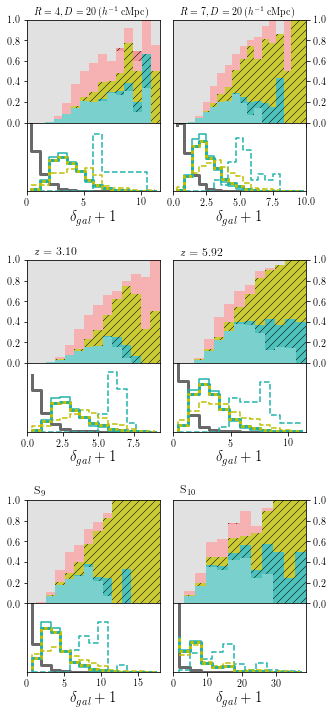

In [122]:
fig = plt.figure(figsize=(5, 12))

gs = gridspec.GridSpec(19, 2)
gs.update(wspace=0.1, hspace=0)

ax1 = fig.add_subplot(gs[0:3,0])
ax1b = fig.add_subplot(gs[3:5,0])

ax2 = fig.add_subplot(gs[0:3,1])
ax2b = fig.add_subplot(gs[3:5,1])

ax3 = fig.add_subplot(gs[7:10,0])
ax3b = fig.add_subplot(gs[10:12,0])

ax4 = fig.add_subplot(gs[7:10,1])
ax4b = fig.add_subplot(gs[10:12,1])

ax5 = fig.add_subplot(gs[14:17,0])
ax5b = fig.add_subplot(gs[17:19,0])

ax6 = fig.add_subplot(gs[14:17,1])
ax6b = fig.add_subplot(gs[17:19,1])

N = 19

Ridx = zidx = 1

plotit(ax1, dgal_sfr_3p95_r4_random, 0, 2, axb=ax1b, N=N, clim=0.4, plim=0.7)
ax1.text(0.05,1.05,'$R = 4, D = 20 \, (h^{-1} \; \mathrm{cMpc})$', transform=ax1.transAxes, size=10)

plotit(ax2, dgal_sfr_3p95_r7_random, 0, 2, axb=ax2b, N=N, clim=0.7, plim=0.45)
ax2.text(0.05,1.05,'$R = 7,  D = 20\, (h^{-1} \; \mathrm{cMpc})$', transform=ax2.transAxes, size=10)

plotit(ax3, dgal_sfr_3p10_r7_random, 0, 1, clim=0.7, plim=0.5, N=N, axb = ax3b)
ax3.text(0.05,1.05,'$z = 3.10$', transform=ax3.transAxes, size=12)

plotit(ax4, dgal_sfr_5p92_r7_random, 0, 1, clim=0.6, plim=0.6, N=N, axb = ax4b)
ax4.text(0.05,1.05,'$z = 5.92$', transform=ax4.transAxes, size=12)

plotit(ax5, dgal_stellarMass_3p95__r7_random, 0, 1, N=N, clim=0.7, plim=0.6, axb=ax5b)
ax5.text(0.05,1.05,'$\mathrm{S}_9$', transform=ax5.transAxes, size=12)

plotit(ax6, dgal_stellarMass10_3p95_r7_random, 0, 1, N=N, clim=0.7, plim=0.7, axb=ax6b)
ax6.text(0.05,1.05,'$\mathrm{S}_{10}$', transform=ax6.transAxes, size=12)


for ax in [ax2,ax4,ax6]:
    ax.yaxis.tick_right()
    
for ax in [ax1b,ax2b,ax3b,ax4b,ax5b,ax6b]:
    ax.set_yticks([])
    ax.set_xlabel('$\delta_{gal} + 1$', size=15)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.set_xticklabels([])


# plt.savefig(out_directory+'probabilities_depth.png', bbox_inches='tight', dpi=300)

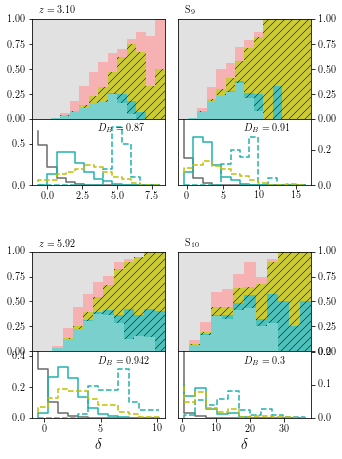

In [38]:
fig = plt.figure(figsize=(5, 11))

gs = gridspec.GridSpec(18, 2)

gs.update(wspace=0.1, hspace=0) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0:3,0])
ax1b = fig.add_subplot(gs[3:5,0])

ax2 = fig.add_subplot(gs[7:10,0])
ax2b = fig.add_subplot(gs[10:12,0])


N = 19

ax1.text(0.05,1.05,'$z = 3.10$', transform=ax1.transAxes)
plotit(ax1, dgal_sfr_3p10_r7_random, 0, 1, clim=0.7, plim=0.5, N=N, axb = ax1b)

ax2.text(0.05,1.05,'$z = 5.92$', transform=ax2.transAxes)
plotit(ax2, dgal_sfr_5p92_r7_random, 0, 1, clim=0.6, plim=0.6, N=N, axb = ax2b)


ax3 = fig.add_subplot(gs[0:3,1])
ax3b = fig.add_subplot(gs[3:5,1])

ax4 = fig.add_subplot(gs[7:10,1])
ax4b = fig.add_subplot(gs[10:12,1])

plotit(ax3, dgal_stellarMass_3p95__r7_random, 0, 1, N=N, clim=0.7, plim=0.6, axb=ax3b)
ax3.text(0.05,1.05,'$\mathrm{S}_9$', transform=ax3.transAxes)

plotit(ax4, dgal_stellarMass10_3p95_r7_random, 0, 1, N=N, clim=0.7, plim=0.7, axb=ax4b)
ax4.text(0.05,1.05,'$\mathrm{S}_{10}$', transform=ax4.transAxes)


for ax in [ax3,ax4,ax3b,ax4b]:
    ax.yaxis.tick_right()


for ax in [ax2b, ax4b]:
    ax.set_xlabel('$\delta$', size=15)


# plt.savefig(out_directory+'probabilities_B_modified.png', bbox_inches='tight', dpi=300)

AttributeError: 'NoneType' object has no attribute 'set_xlim'

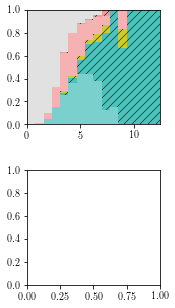

In [21]:
fig = plt.figure(figsize=(5, 8))

gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.4) # bottom = 0.57, top = 1, , wspace=0

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

N = 19


# clim plots
for clim, ax in zip([0.3, 0.7], [ax1,ax2]):
    plotit(ax, dgal_sfr_3p95_r7_random, 0, 1, clim=clim, N=N)
    ax.text(0.05,1.05,'$P = 0.5$, $C = %s$'%clim, transform=ax.transAxes)
    

ax3 = fig.add_subplot(gs[0,1])
ax4 = fig.add_subplot(gs[1,1])


# selection plots
for plim, ax in zip([0.3, 0.7], [ax3, ax4]):
    plotit(ax, dgal_sfr_3p95_r7_random, 0, 1, plim=plim, N=N)
    ax.text(0.05,1.05,'$P = %s$, $C = 0.5$'%plim, transform=ax.transAxes)
    ax.yaxis.tick_right()
    

ax5 = fig.add_subplot(gs[2,0])
ax6 = fig.add_subplot(gs[2,1])

for plim, clim, ax in zip([0.25, 0.7], [0.25, 0.7], [ax5, ax6]):
    plotit(ax, dgal_sfr_3p95_r7_random, 0, 1, plim=plim, clim=clim, N=N)
    ax.text(0.05,1.05,'$P = %s$, $C = %s$'%(plim, clim), transform=ax.transAxes)
    

ax6.yaxis.tick_right()    
    
for ax in [ax5, ax6]:
    ax.set_xlabel('$\delta$', size=15)


# plt.savefig(out_directory+'probabilities_C.png', bbox_inches='tight', dpi=300)